# Delineate Ridge Areas
This notebook demonstrates how ScrollStats delineates ridge areas from an input DEM.

Ridge area delineation is accomplished with the following operations:
1. apply profile curvature and residual topography transformations
2. apply binary classification to the transformed rasters
3. find the agreement between the binary rasters
4. denoise the agreement raster


## Convenience Functions

Each of the numbered steps above are shown in detail in this notebook. However, the convenience function `create_ridge_area_raster` or `create_ridge_area_raster_fs` should be used to execute all of these steps at once.

- `create_ridge_area_raster` takes as input and returns python objects in memory so that the user can use this function with other python processes.
- `create_ridge_area_raster_fs` is just a wrapper for `create_ridge_area_raster` and takes as input and returns file paths. 

See example usage of both convenience functions at the end of the notebook.


In [1]:
from __future__ import annotations

from functools import partial
from pathlib import Path

import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import rasterio
import rasterio.mask
from matplotlib.colors import BoundaryNorm, ListedColormap
from scipy import ndimage

from parameters import RASTER_WINDOW_SIZE, SMALL_FEATS_SIZE
from scrollstats.delineation import (
    create_ridge_area_raster,
    create_ridge_area_raster_fs,
)
from scrollstats.delineation.raster_classifiers import (
    quadratic_profile_curvature,
    residual_topography,
)
from scrollstats.delineation.raster_denoisers import remove_small_feats_w_flip

# import underlying delineation functions for demonstration
from scrollstats.delineation.ridge_area_raster import clip_raster

## Define Inputs

### Set input paths and output directory

In [2]:
# Input Paths
dem_path = Path("example_data/input/LBR_025_dem.tif")
bend_path = Path("example_data/input/LBR_025_bend.geojson")

# Output Directory
output_dir = Path("example_data/output")

## 1. Calculate Profile Curvature and Residual Topography
- ScrollStats uses Profile Curvature (a measure of convexity) and Residual Topography (a measure of prominence) to identify ridge areas in the DEM
    - Both of these transformations can be classified into "ridge" and "not ridge" areas by applying a threshold at 0, creating a binary raster.
- Using two independent metrics to identify ridge areas, we can be confident that the union of these two binary rasters represent the true ridge locations within the DEM  

In [3]:
# Open the DEM dataset
dem_handle = rasterio.open(dem_path)
dem = dem_handle.read(1)

# Find no data pixels
if np.isnan(dem_handle.nodata):
    no_data_mask = np.isnan(dem_handle.read(1))
else:
    no_data_mask = dem == dem_handle.nodata

# Set no data values to absurd integer to avoid errors from the classifier functions with infinite values
dem[no_data_mask] = -99999

In [4]:
profc = quadratic_profile_curvature(dem, RASTER_WINDOW_SIZE, dx=1)

rt = residual_topography(dem, RASTER_WINDOW_SIZE)

Profile Curvature: 100%|##########| 5073285/5073285 [02:01<00:00, 41691.27it/s]


Residual Topography: Complete (3.8s elapsed)


## DEM vs Residual Topography example 

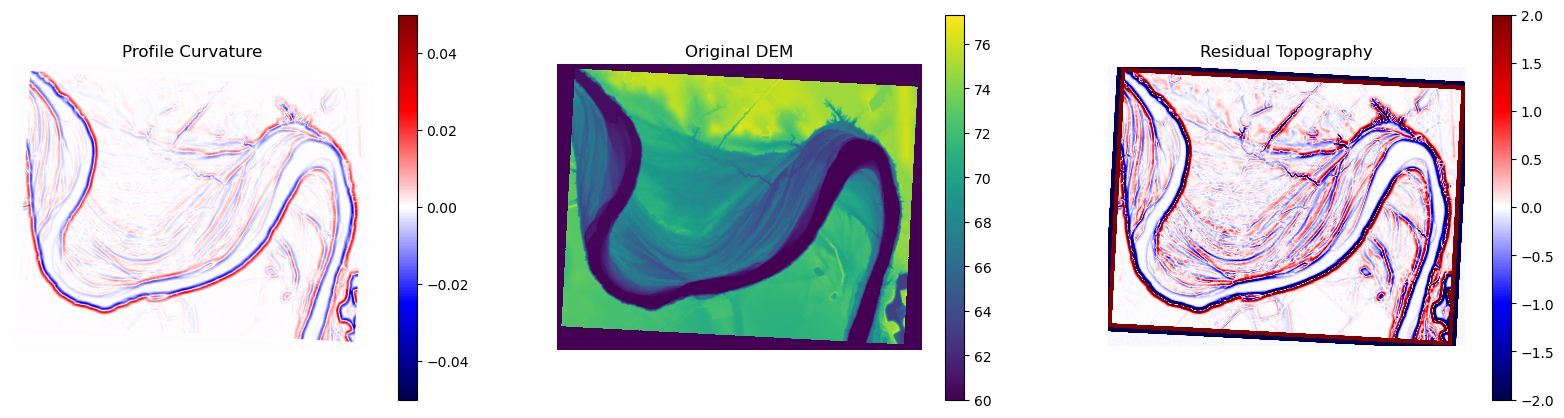

In [5]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 5))


mapper = ax1.imshow(profc, vmin=-0.05, vmax=0.05, cmap="seismic")
fig.colorbar(mapper, ax=ax1)
ax1.set_axis_off()
ax1.set_title("Profile Curvature")

mapper = ax2.imshow(dem, vmin=60)
fig.colorbar(mapper, ax=ax2)
ax2.set_axis_off()
ax2.set_title("Original DEM")

mapper = ax3.imshow(rt, vmin=-2, vmax=2, cmap="seismic")
fig.colorbar(mapper, ax=ax3)
ax3.set_axis_off()
ax3.set_title("Residual Topography");

## Apply binary classification
```python
if px > 0:
    px == 1
if px <= 0:
    px == 0
```

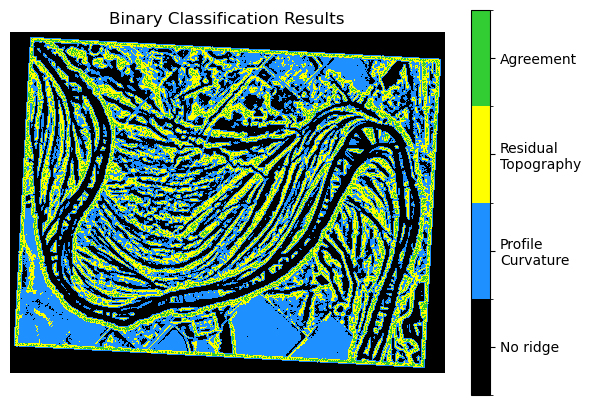

In [6]:
profc_bc = profc > 0
rt_bc = rt > 0

profc_vis = np.zeros(profc.shape)
profc_vis[profc_bc] = 1

rt_vis = np.zeros(rt_bc.shape)
rt_vis[rt_bc] = 10

comp_vis = profc_vis + rt_vis

fig, ax = plt.subplots(1, 1, figsize=(7, 5))
cmap = ListedColormap(["k", "dodgerblue", "yellow", "limegreen"])
bounds = np.array([0, 1, 10, 11, 12])
norm = BoundaryNorm(bounds, cmap.N)
img = ax.imshow(comp_vis, cmap=cmap, norm=norm)
ax.set_axis_off()
ax.set_title("Binary Classification Results")

cbar = plt.colorbar(img)
cbar.set_ticks([0.5, 5.5, 10.5, 11.5], minor=False)
cbar.ax.set_yticklabels(
    ["No ridge", "Profile\nCurvature", "Residual\nTopography", "Agreement"]
);

### Create agreement raster

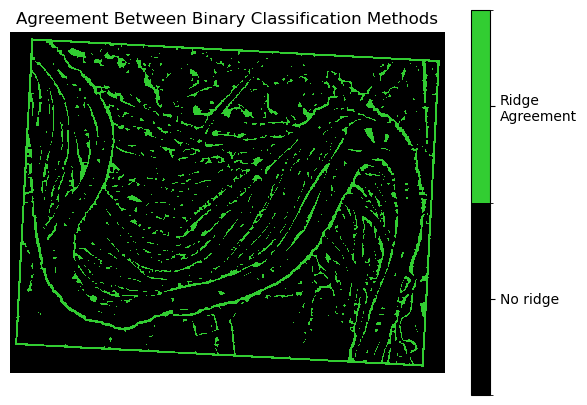

In [7]:
agr = profc_bc & rt_bc

fig, ax = plt.subplots(1, 1, figsize=(7, 5))
cmap = ListedColormap(["k", "limegreen"])
bounds = np.array([0, 1, 2])
norm = BoundaryNorm(bounds, cmap.N)
img = ax.imshow(agr, cmap=cmap, norm=norm)
ax.set_axis_off()
ax.set_title("Agreement Between Binary Classification Methods")

cbar = plt.colorbar(img)
cbar.set_ticks([0.5, 1.5], minor=False)
cbar.ax.set_yticklabels(["No ridge", "Ridge\nAgreement"]);

### Clip DEM and Agreement raster

**NOTE:** Details on how to create the bend area polygon are contained in the next notebook, but the polygon is being used now to clip the rasters. 

This greatly reduces the number of raster features before denoising and keeps all of the raster processing in one notebook


In [8]:
bend = gpd.read_file(bend_path)
bend_geom = bend.loc[0, "geometry"]


dem_clip, dem_mask, dem_meta = clip_raster(dem_handle, bend_geom, no_data=np.nan)
agr_clip, agr_mask, agr_meta = clip_raster(
    dem_handle, bend_geom, array=agr, no_data=np.nan
)

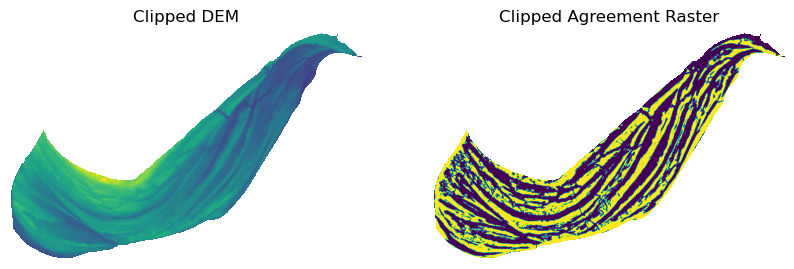

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))

mapper = ax1.imshow(dem_clip)
ax1.set_axis_off()
ax1.set_title("Clipped DEM")

agr_clip_vis = agr_clip.astype(float)
agr_clip_vis[agr_mask] = np.nan

mapper = ax2.imshow(agr_clip_vis)
ax2.set_axis_off()
ax2.set_title("Clipped Agreement Raster");

### Denoise agreement raster

In [10]:
denoiser_funcs = [
    ndimage.binary_closing,
    ndimage.binary_opening,
    partial(remove_small_feats_w_flip, small_feats_size=SMALL_FEATS_SIZE),
]

# Denoise the binary array
ridge_area_array = agr_clip.copy()
for func in denoiser_funcs:
    ridge_area_array = func(ridge_area_array)

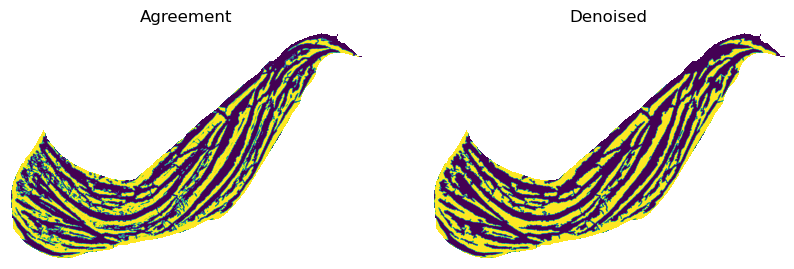

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))

mapper = ax1.imshow(agr_clip_vis)
ax1.set_axis_off()
ax1.set_title("Agreement")

ridge_area_array_vis = ridge_area_array.astype(float)
ridge_area_array_vis[agr_mask] = np.nan
mapper = ax2.imshow(ridge_area_array_vis)
ax2.set_axis_off()
ax2.set_title("Denoised");

# Convenience functions
- **`create_ridge_area_raster`** takes a `rasterio.DatasetReader` of the DEM, a shapely `Polygon` of the bend area and any other kwargs as input and returns two `np.ndarray` objects (the clipped ridge area raster and clipped DEM) and the modified `rasterio` metadata to write the arrays to disk if needed

- **`create_ridge_area_raster_fs`** is just a wrapper for `create_ridge_area_raster` taking and returning file paths to act as an interface for the file system

Profile Curvature: 100%|##########| 5073285/5073285 [01:59<00:00, 42283.98it/s]


Residual Topography: Complete (3.8s elapsed)


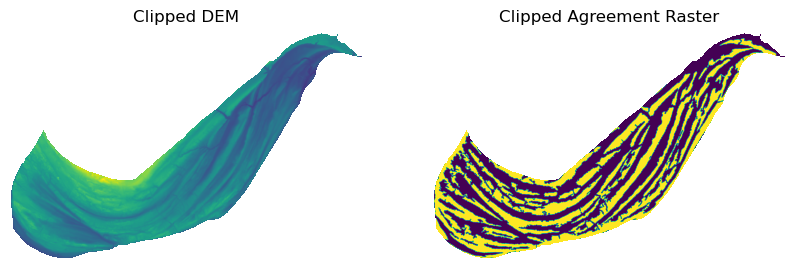

In [12]:
dem_ds = rasterio.open(dem_path)

bend = gpd.read_file(bend_path)
bend_geom = bend.loc[0, "geometry"]

agr_clip, dem_clip, clip_meta = create_ridge_area_raster(
    dem_ds=dem_ds,
    geometry=bend_geom,
    no_data=np.nan,
    window=RASTER_WINDOW_SIZE,
    dx=1,
    small_feats_size=SMALL_FEATS_SIZE,
)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))

mapper = ax1.imshow(dem_clip)
ax1.set_axis_off()
ax1.set_title("Clipped DEM")

mapper = ax2.imshow(agr_clip)
ax2.set_axis_off()
ax2.set_title("Clipped Agreement Raster");

Profile Curvature: 100%|##########| 5073285/5073285 [01:59<00:00, 42332.03it/s]


Residual Topography: Complete (3.8s elapsed)
Wrote ridge area raster to disk: example_data/output/LBR_025_dem_ridge_area_raster.tif
Wrote clipped DEM to disk: example_data/output/LBR_025_dem_clip.tif


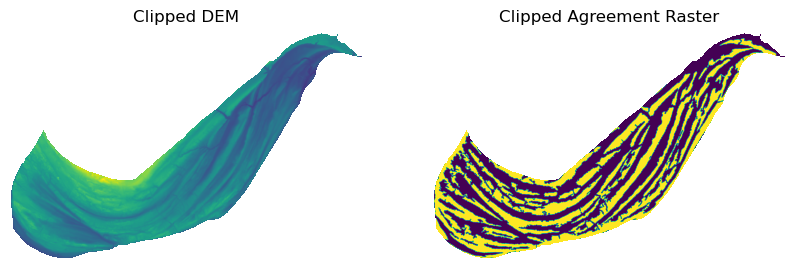

In [13]:
binary_path_out, dem_path_out = create_ridge_area_raster_fs(
    dem_path=dem_path,
    geometry_path=bend_path,
    out_dir=output_dir,
    no_data=np.nan,
    window=RASTER_WINDOW_SIZE,
    dx=1,
    small_feats_size=SMALL_FEATS_SIZE,
)


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))

dem_clip = rasterio.open(dem_path_out).read(1)
mapper = ax1.imshow(dem_clip)
ax1.set_axis_off()
ax1.set_title("Clipped DEM")

agr_clip = rasterio.open(binary_path_out).read(1)
mapper = ax2.imshow(agr_clip)
ax2.set_axis_off()
ax2.set_title("Clipped Agreement Raster");

## Move on to [`CreateVectorDatasets.ipynb`](CreateVectorDatasets.ipynb)
- [`CreateVectorDatasets.ipynb`](CreateVectorDatasets.ipynb) will walk through the processes and rationale for creating the vector datasets needed for ScrollStats
- The ridge area raster created from this notebook will be used in later notebooks
